# Features comparison

This notebook discusses predictions made using some different feature- and target combinations. The models used (*A*, *B*, *C*, *D* and *E*) are as described in the thesis. A quick summary:
- **Model A** uses three temperatures and process flow rate to predict outlet cooling temperature
- **Model B** uses three temperatures, process flow rate and coolant valve opening to predict outlet cooling temperature
- **Model C** uses three temperatures, process flow rate and coolant flow rate to predict outlet cooling temperature
- **Model D** uses three temperatures, process flow rate, coolant valve opening and coolant inlet pressure to predict outlet cooling temperature
- **Model E** uses three temperatures, process flow rate, coolant valve opening, coolant flow rate and coolant inlet pressure to predict outlet cooling temperature

Additionally, the process side pressure drop is included as a predicted (target) column whenever this is present in the dataset, which is the case for dataset *D* and *G*.

The stateful high-level API is used with some additional methods. Once more, the functionality of this notebook exceeds the primary intents for the high-level API, and thus does not follow the same recipe as the *basic examples*. Understanding the implemented python methods is not required in order to interpret the results, and therefore the implementation is not discussed in detail.

## Step 0: Import modules

In [1]:
# %load features_comparison.py
import src.core as mlApi
from src.utils.plots import (plotModelPredictions, plotModelScores, getPlotColors)
from src.utils.prints import (printModelScores)
import matplotlib.pyplot as plt
import src.core_configs as configs

colors = getPlotColors()
models = ['A', 'B', 'C', 'D', 'E']

Using TensorFlow backend.


## Step 1: Implement required methods

A method is implemented to perform the feature comparison. It takes as input a complete dataset configuration, including a list of irrelevant columns configurations that define each model. The provided column configurations are looped and predictions are gathered for each configuration. It is recommended to use only one machine learning model type (e.g. MLP/LSTM/Linear) at each time in order to achieve readable output plots. Predictions and metrics are gathered for each loop and eventually ploted/printed.

In [2]:
def featureComparison(
	irrelevantColumnsList,
	filename,
	columns,
	traintime,
	testtime,
	targetColumns,
	enrolWindow,
	):
	global colors, models

	columnsLists = []
	deviationsLists= []
	names = []
	trainmetrics = []
	testmetrics = []

	for i, irrelevantColumns in enumerate(irrelevantColumnsList):
		mlApi.reset()

		df = mlApi.initDataframe(filename, columns, irrelevantColumns)
		df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
		X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)
		
		linear_model = mlApi.Linear_Regularized("Linear " + models[i])
		mlp_model = mlApi.MLP("MLPd " + models[i], layers=[64, 64], dropout=0.2, epochs=2000)
		lstm_model = mlApi.LSTM("LSTMd " + models[i], layers=[64, 64], dropout=0.2, recurrentDropout=0.2, epochs=500, enrolWindow=enrolWindow)

		modelList = [
			#linear_model,
			mlp_model,
			#lstm_model,
		]

		mlApi.initModels(modelList)
		retrain=False
		mlApi.trainModels(retrain)

		modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(plot=True, score=True)

		if i < 1:
			columnsLists = columnsList
			deviationsLists = deviationsList
			all_names = modelNames
			all_train_metrics = metrics_train
			all_test_metrics = metrics_test
		else:
			for j_target in range(len(columnsList)):
				for k_model in range(1, len(columnsList[j_target])):
					columnsLists[j_target].append(columnsList[j_target][k_model])
				for k_model in range(0, len(deviationsList[j_target])):
					deviationsLists[j_target].append(deviationsList[j_target][k_model])
			all_names = [*all_names, *modelNames]
			all_train_metrics = [*all_train_metrics, *metrics_train]
			all_test_metrics = [*all_test_metrics, *metrics_test]

		names.append(modelNames)
		trainmetrics.append(metrics_train)
		testmetrics.append(metrics_test)

	indexColumn = mlApi._indexColumn
	columnDescriptions = mlApi._columnDescriptions
	columnUnits = mlApi._columnUnits
	traintime = mlApi._traintime

	for i in range(len(deviationsLists)):
		for j in range(len(deviationsLists[i])):
			deviationsLists[i][j][3] = colors[j]

	for i in range(len(columnsLists)):
		columnsList[i][0][3] = 'red'
		for j in range(1, len(columnsLists[i])):
			columnsLists[i][j][3] = colors[j-1]

	printModelScores(
		all_names,
		all_train_metrics,
		all_test_metrics,
	)
	plotModelPredictions(
		plt,
		deviationsLists,
		columnsLists,
		indexColumn,
		columnDescriptions,
		columnUnits,
		traintime,
		interpol=False,
	)
	plotModelScores(
		plt,
		all_names,
		all_train_metrics,
		all_test_metrics,
	)

## Step 2: Define configurations

### Configurations dataset D

In [3]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('D', None, '30min')
targetColumns = [
	'50TT002',
	'20PDT001',
]
irrelevantColumnsList = [
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in 
	[
		'20PT001',
		'50PDT001',
		'50FT001',
		'50TV001',
		'50PT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C valve
	[
		'20PT001',
		'50PDT001',
		'50FT001',
		'50PT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C flow
	[
		'20PT001',
		'50PDT001',
		'50TV001',
		'50PT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C P in, C valve
	[
		'20PT001',
		'50PDT001',
		'50FT001',
	],
	#  Target: C T out, P dP
	#  Featers: P T in, P T out, P flow, C T in, C P in, C valve, C flow
	[
		'20PT001',
		'50PDT001',
	],
]

## Step 3: Make predictions

Configurations and predictions are made separately for each dataset, in order to increase readability and explainability of output. Even so, the output sequence is quite long, so detailed explainations are provided following each dataset output.

### Predictions dataset D

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 20PDT001 - Process Pressure Difference
Col. 4 : 50TT001 - Coolant Inlet Temperature
Col. 5 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model MLPd A was loaded from file
+-------

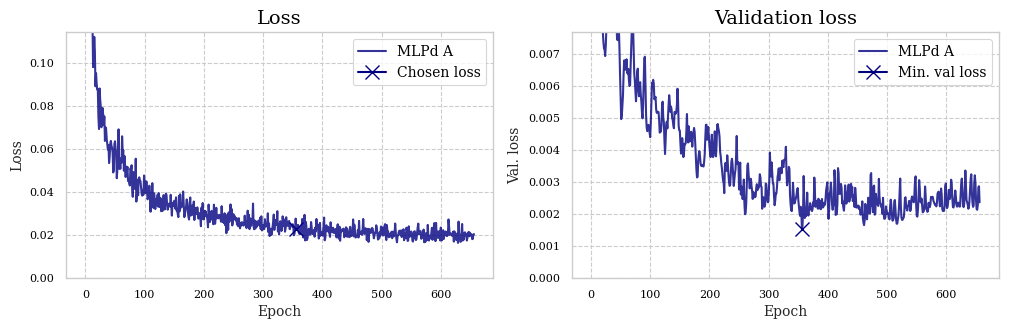

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.9955   |   0.8513   |
+--------+-------------+------------+


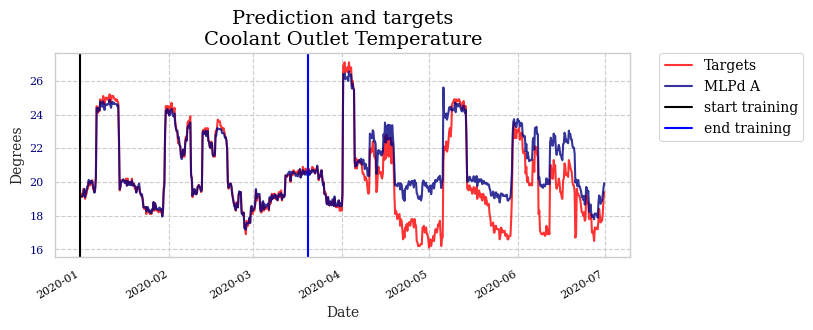

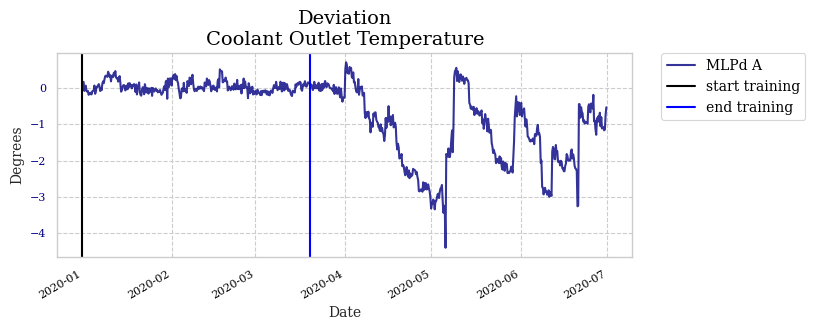

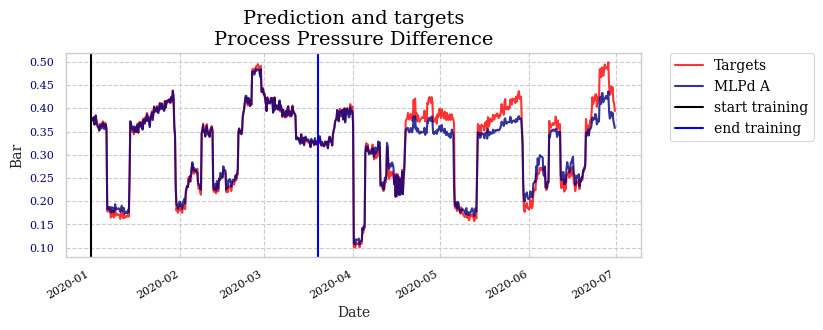

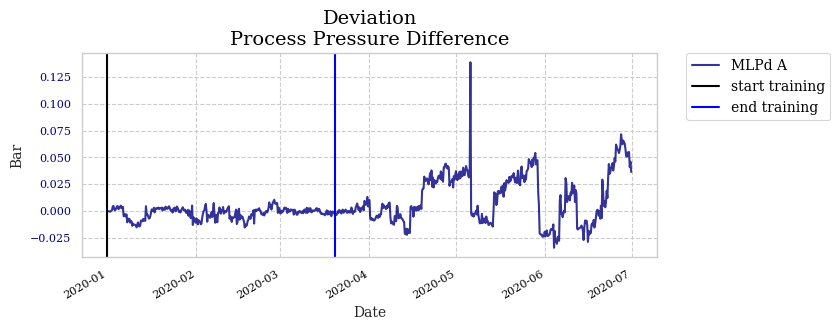

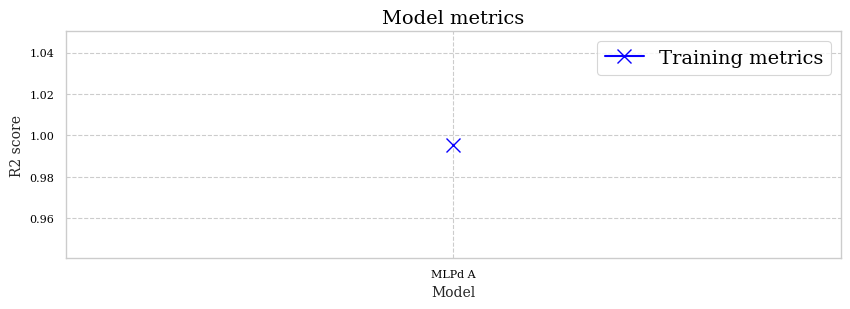

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 20PDT001 - Process Pressure Difference
Col. 4 : 50TT001 - Coolant Inlet Temperature
Col. 5 : 50TT002 - Coolant Outlet Temperature
Col. 6 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

M

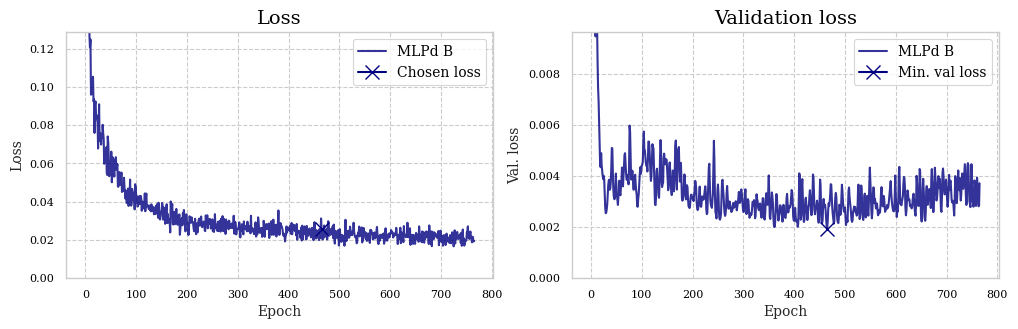

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd B |    0.9969   |   0.932    |
+--------+-------------+------------+


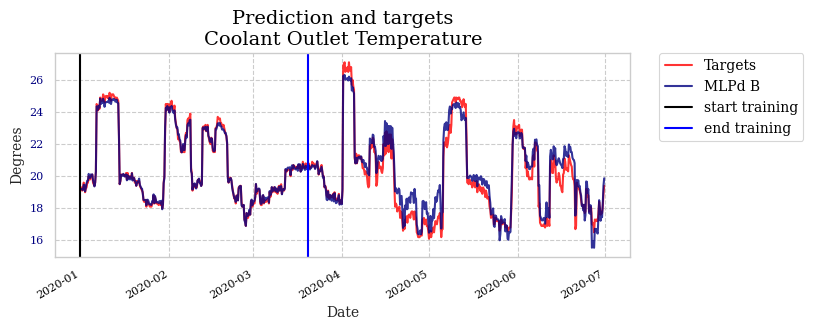

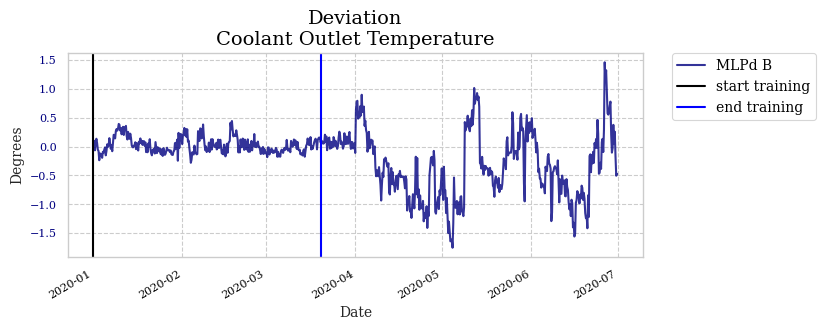

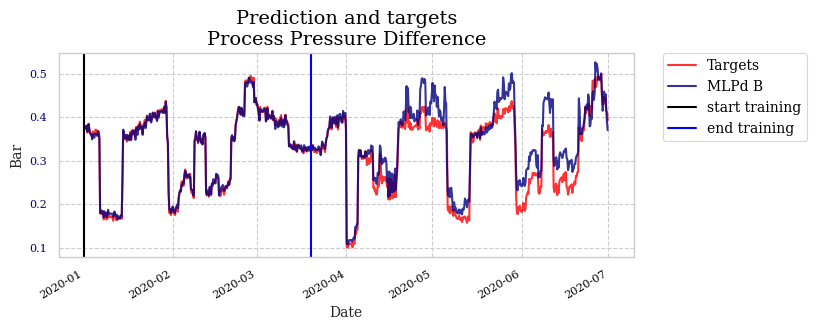

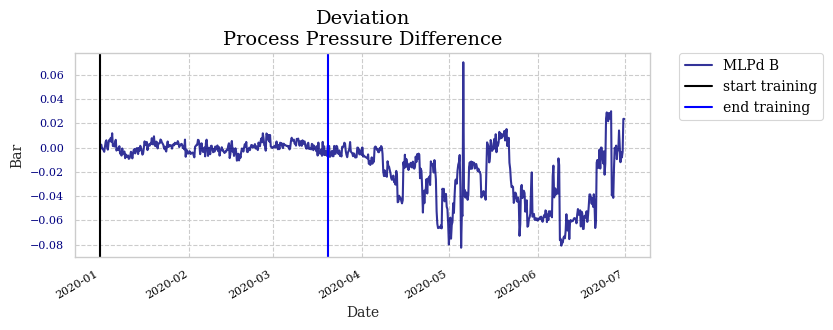

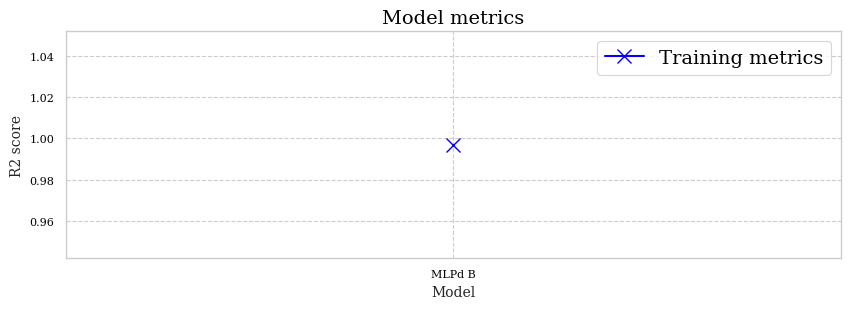

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 20PDT001 - Process Pressure Difference
Col. 4 : 50TT001 - Coolant Inlet Temperature
Col. 5 : 50FT001 - Coolant Flow Rate
Col. 6 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows

Model

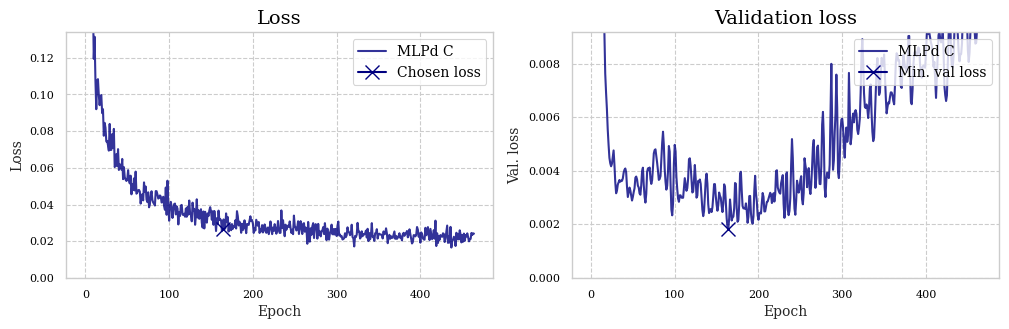

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd C |    0.9973   |   0.8866   |
+--------+-------------+------------+


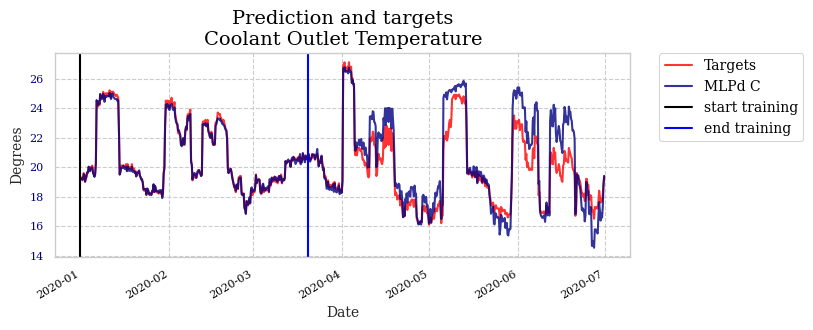

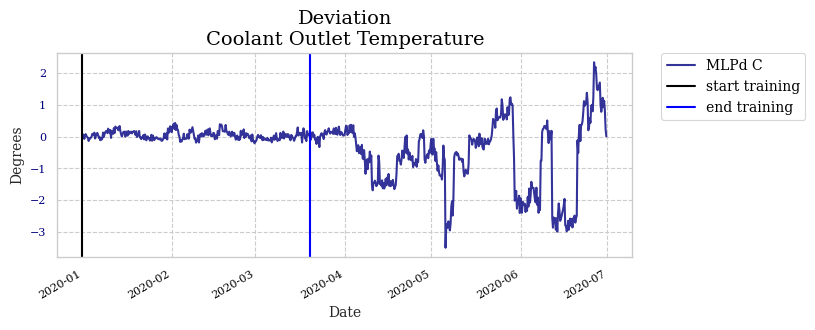

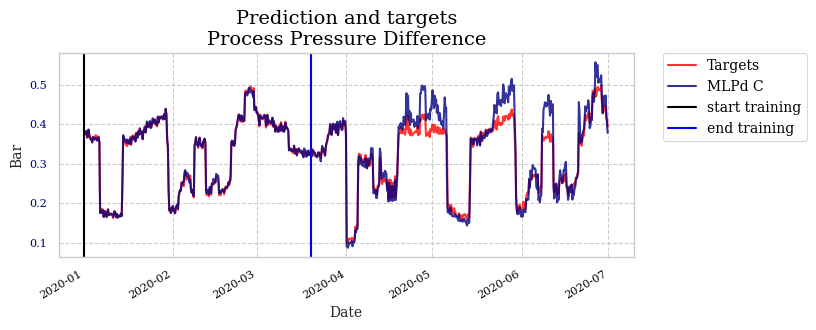

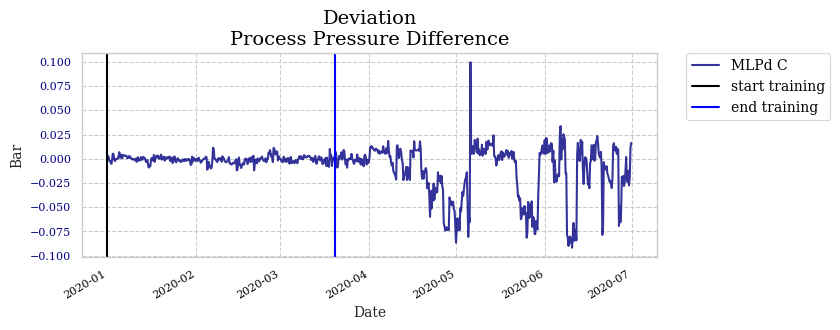

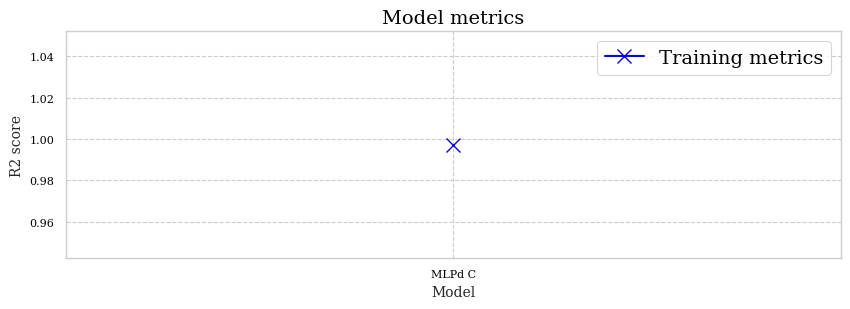

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 20PDT001 - Process Pressure Difference
Col. 4 : 50TT001 - Coolant Inlet Temperature
Col. 5 : 50PT001 - Coolant Inlet Pressure
Col. 6 : 50TT002 - Coolant Outlet Temperature
Col. 7 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00

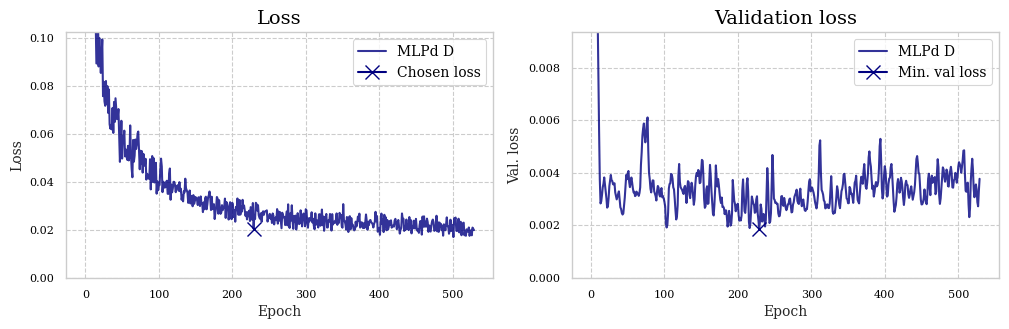

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd D |    0.9954   |   0.9284   |
+--------+-------------+------------+


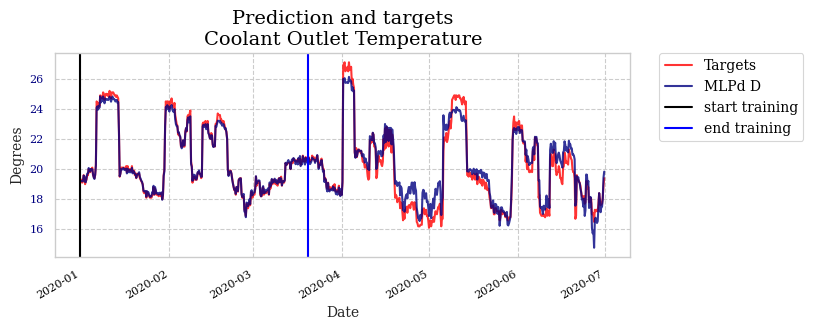

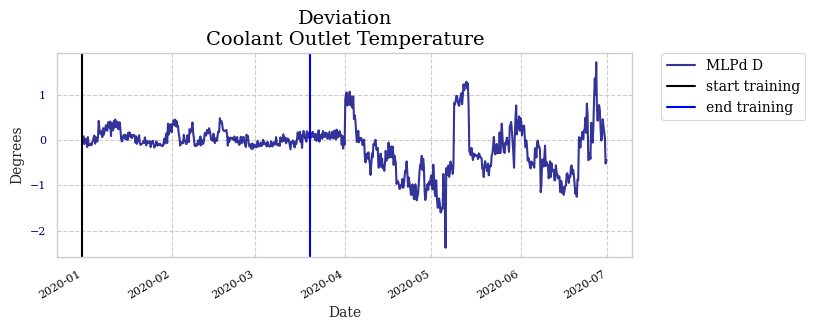

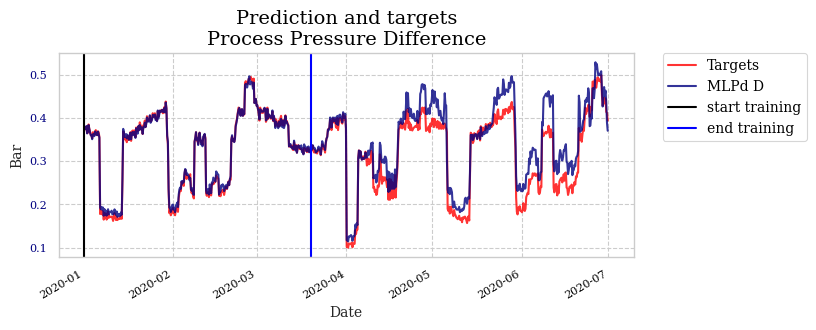

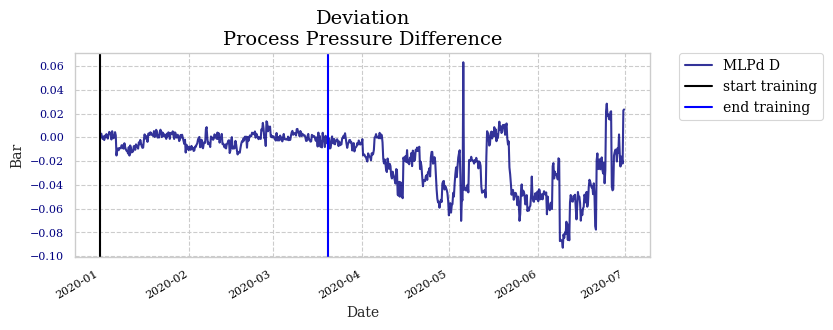

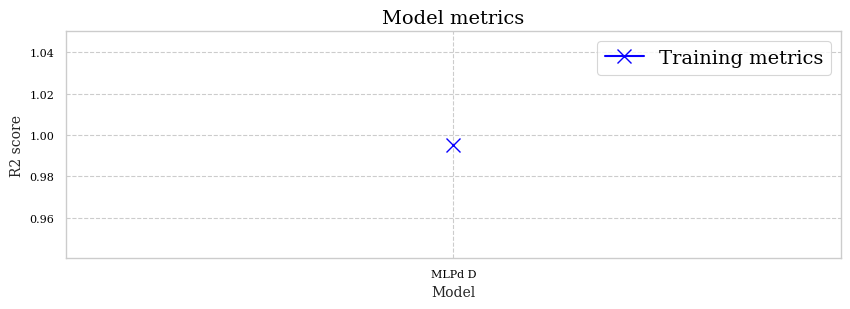

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 20PDT001 - Process Pressure Difference
Col. 4 : 50TT001 - Coolant Inlet Temperature
Col. 5 : 50PT001 - Coolant Inlet Pressure
Col. 6 : 50FT001 - Coolant Flow Rate
Col. 7 : 50TT002 - Coolant Outlet Temperature
Col. 8 : 50TV001 - Coolant Valve Opening

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Fin

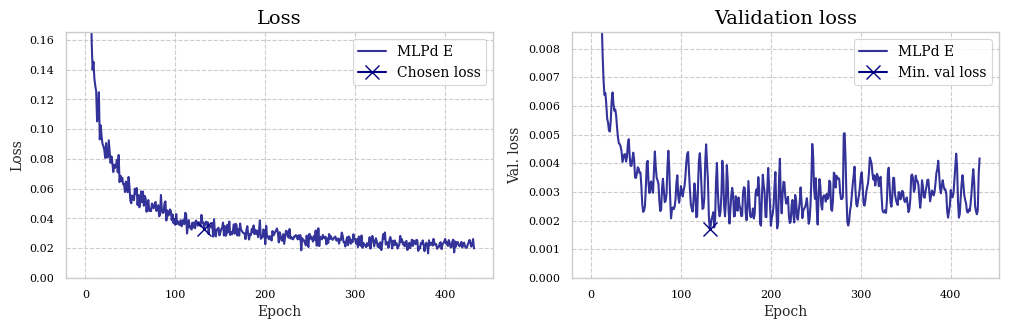

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd E |    0.9954   |   0.9003   |
+--------+-------------+------------+


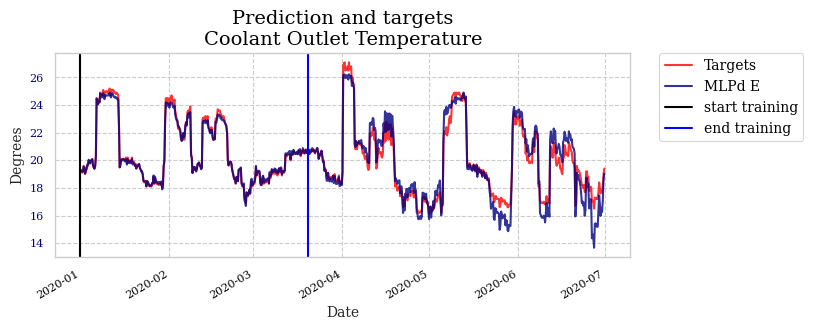

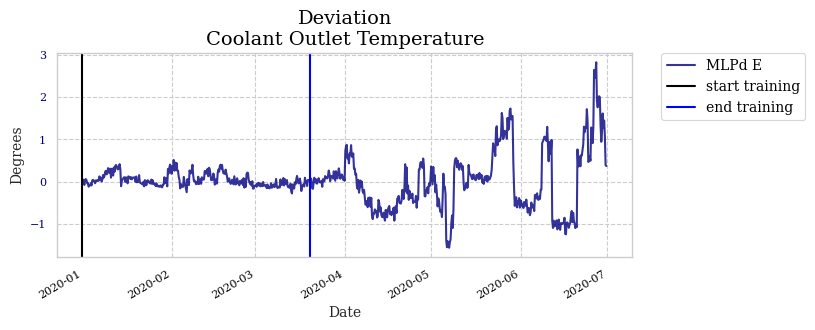

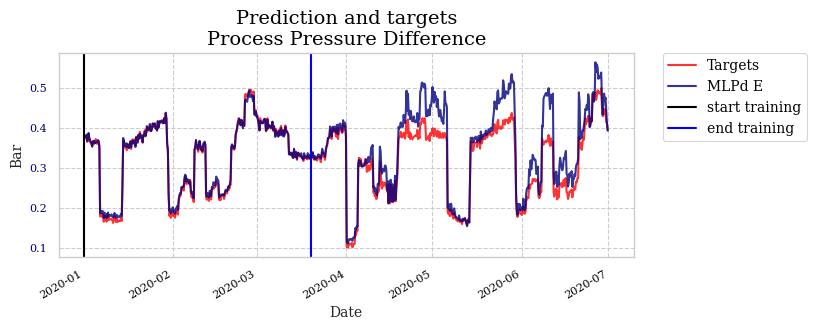

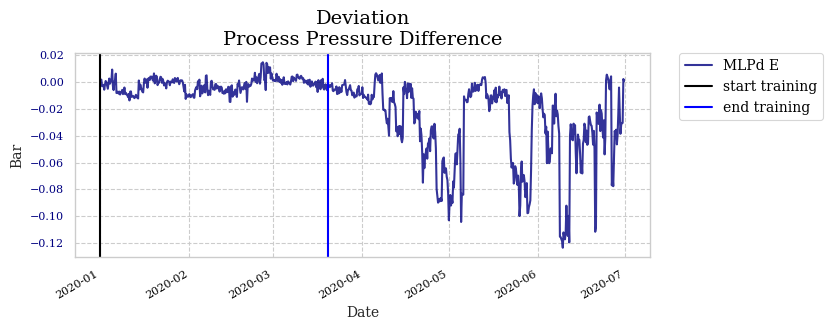

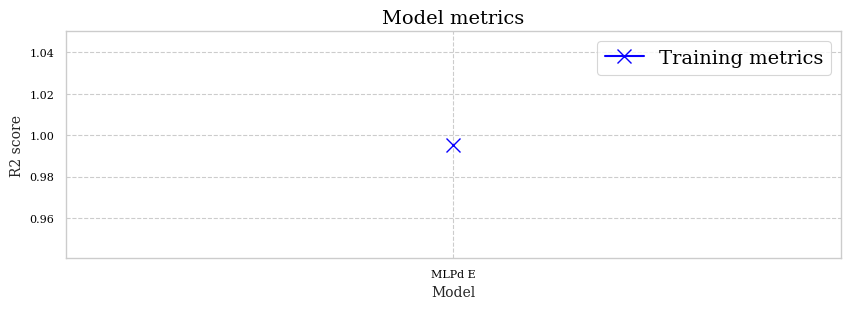

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.9955   |   0.8513   |
| MLPd B |    0.9969   |   0.932    |
| MLPd C |    0.9973   |   0.8866   |
| MLPd D |    0.9954   |   0.9284   |
| MLPd E |    0.9954   |   0.9003   |
+--------+-------------+------------+


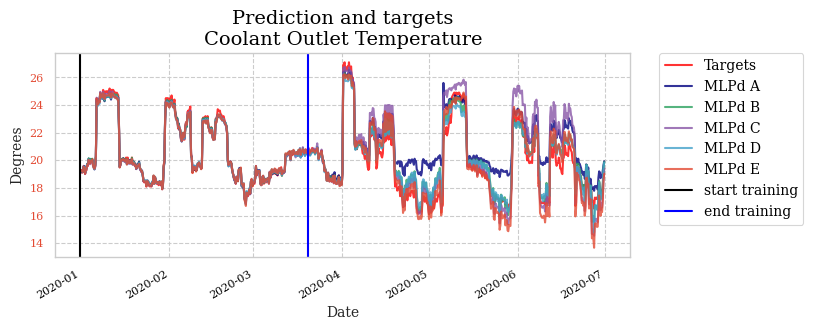

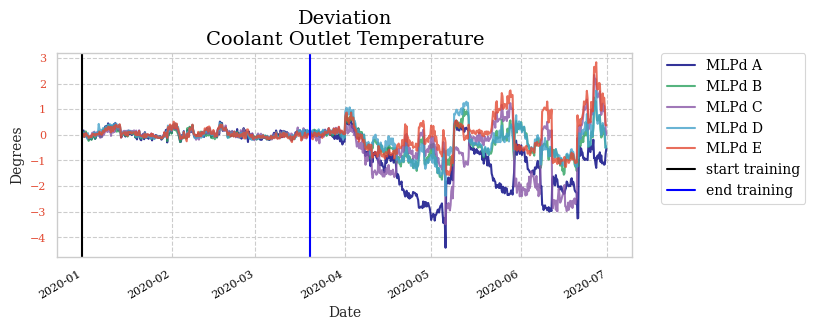

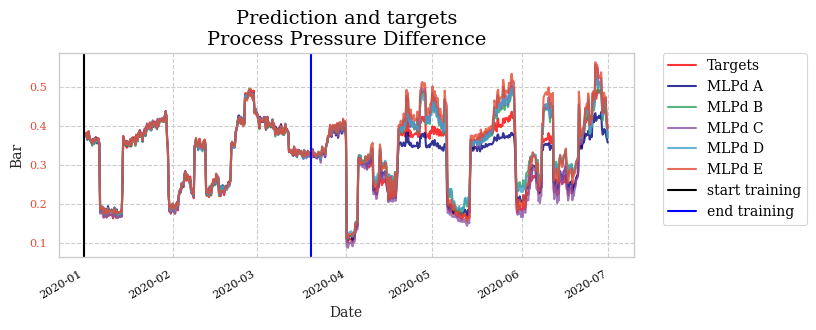

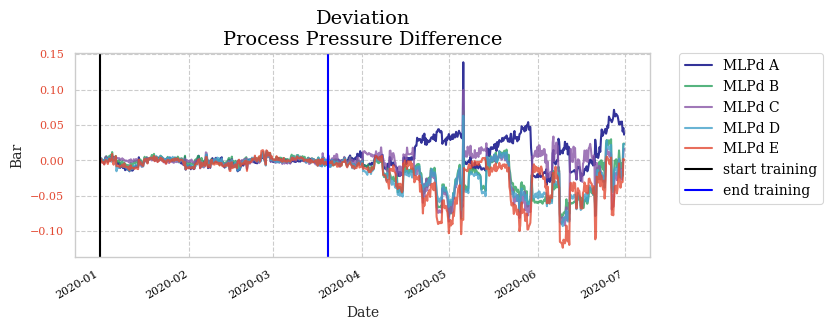

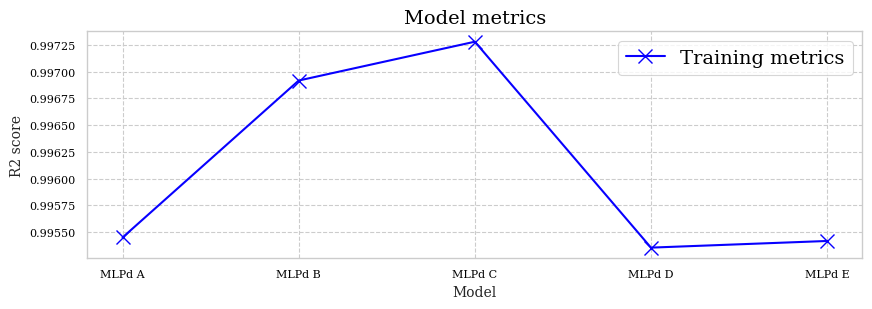

In [4]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 2)

## Discussions, Dataset D

All models have satisfying convergence patterns. Model accuracy, even though comparable in R2-score, reduced considerably with the increase in features. Deviation between measured and predicted Coolant Outlet Temperature is, although generally increasing with added levels of fouling, not accurately represented. Considerable deviation from the expected, linearly increasing pattern are experienced for all models. The model using the least input features appear to give the best fit. 

For the deviation in measured and predicted Process Pressure Difference, the same phenomena as for the linear models can be seen, where model A predicts an entirely different deviation than the remaining models. The same arguments as were made for the linear models, i.e. that this difference in Pressure Difference is not logical with reference to theory, can be made.

### Configurations dataset F

In [5]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('F', None, '30min')
targetColumns = [
	'TT0653_MA_Y'
]
irrelevantColumnsList = [
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in 
	[
		'FT0111',
		'PDT0108_MA_Y',
		'PDT0119_MA_Y',
		'PDT0118_MA_Y',
		'TT0104_MA_Y',
		'TIC0103_CA_YX',
		'TI0115_MA_Y',
		'TT0652_MA_Y',
		'TIC0103_CA_Y',
		'PIC0104_CA_YX',
		'TIC0101_CA_Y',
		'TT0102_MA_Y',
		'TIC0101_CA_YX',
		'TT0651_MA_Y',
		'TIC0105_CA_Y',
	],
	#  Target: C T out
	#  Featers: P T in, P T out, P flow, C T in, C valve
	[
		'FT0111',
		'PDT0108_MA_Y',
		'PDT0119_MA_Y',
		'PDT0118_MA_Y',
		'TT0104_MA_Y',
		'TIC0103_CA_YX',
		'TI0115_MA_Y',
		'TT0652_MA_Y',
		'TIC0103_CA_Y',
		'PIC0104_CA_YX',
		'TIC0101_CA_Y',
		'TT0102_MA_Y',
		'TIC0101_CA_YX',
		'TT0651_MA_Y',
	],
]

### Predictions dataset F

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Valve Opening C

Columns after removal: 
Col. 0 : FYN0111 - Process 

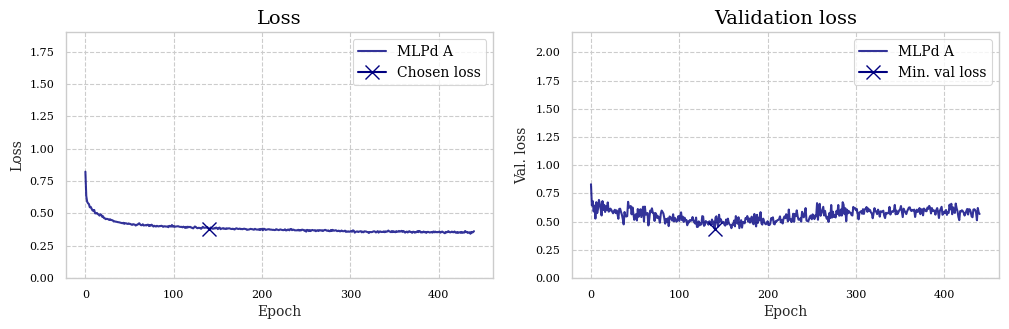

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.6278   |   0.3007   |
+--------+-------------+------------+


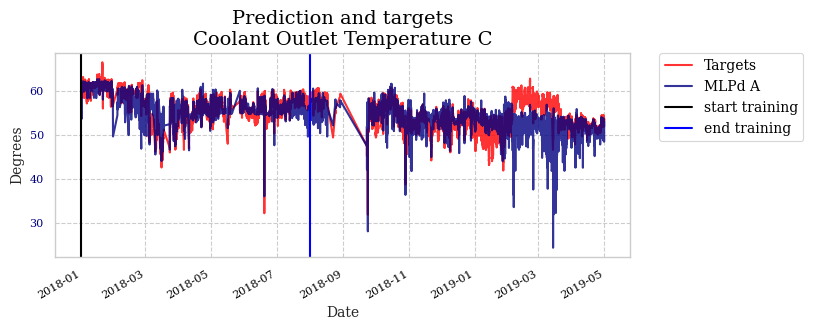

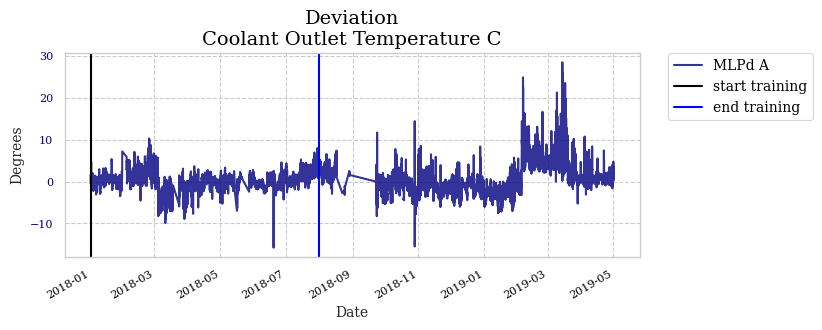

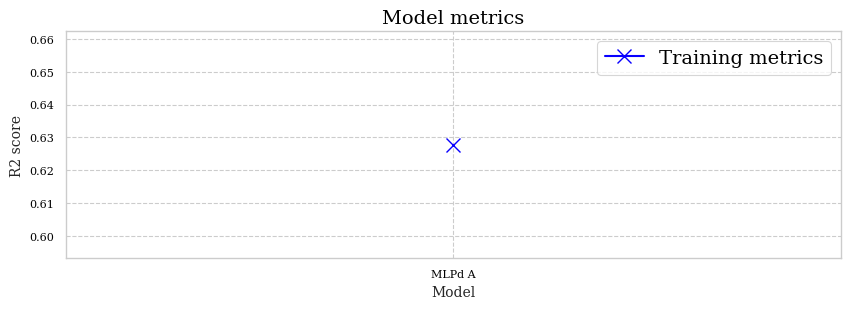

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Valve Opening C

Columns after removal: 
Col. 0 : FYN0111 - Process 

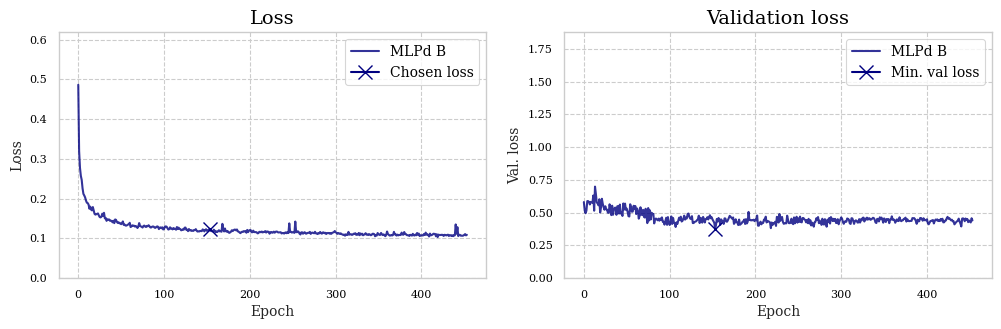

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd B |    0.8474   |   0.3934   |
+--------+-------------+------------+


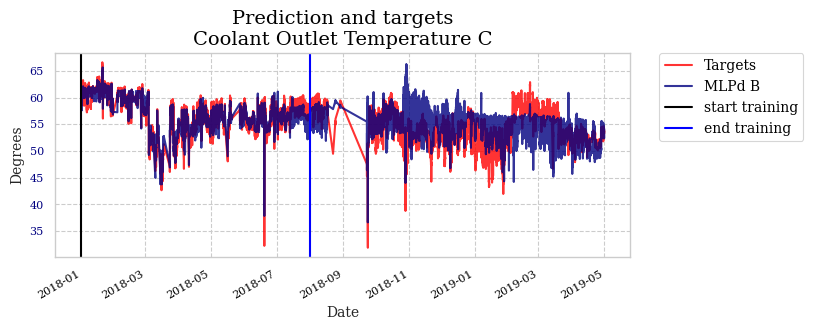

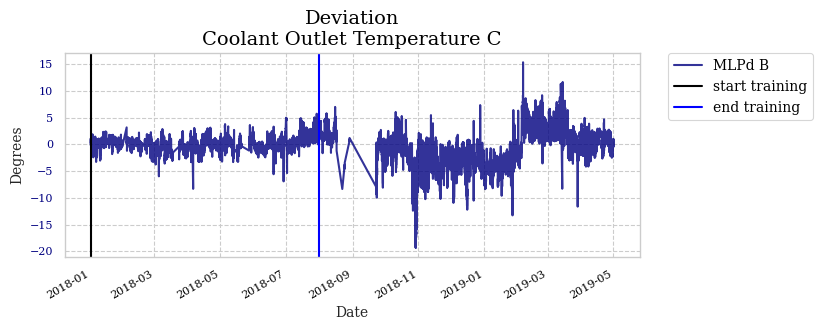

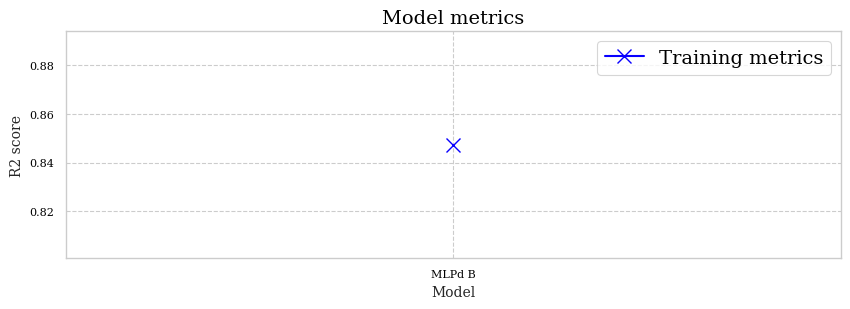

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.6278   |   0.3007   |
| MLPd B |    0.8474   |   0.3934   |
+--------+-------------+------------+


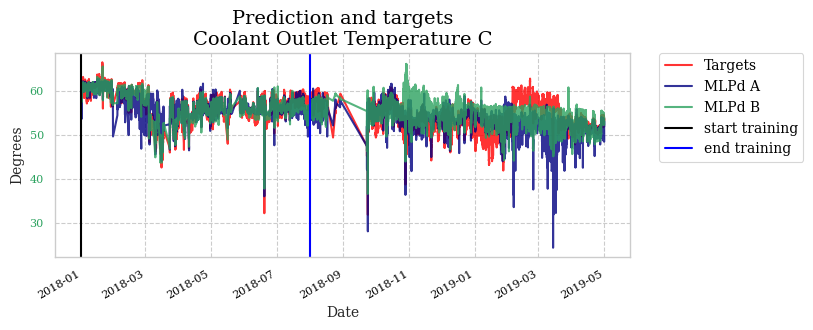

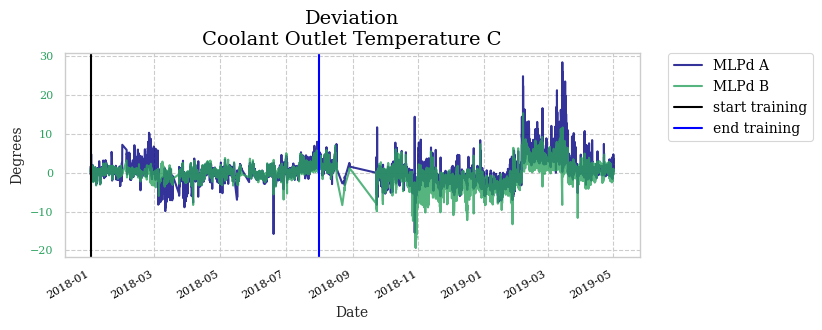

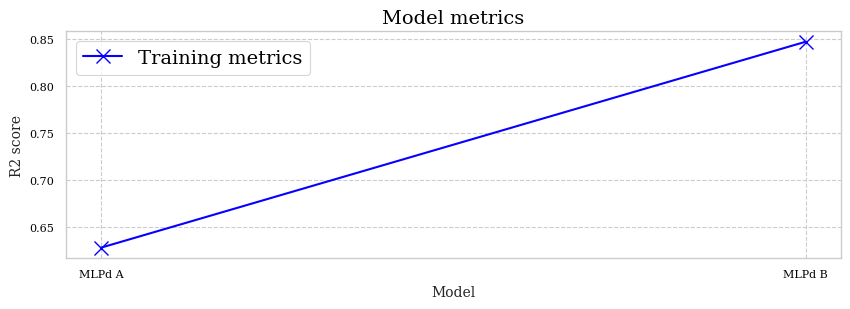

In [6]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 16)

## Discussions, Dataset F

Both models converge and clearly indicate a jump in deviation back to zero when heat exchanger maintenance is performed. Same as for the linear models, model A appears to vary more wildy. Looking at the dataset profiling notebook, it becomes apparent that the Process Inlet Temperature is gradually decreasing while the variation in Process Outlet Temperature and Coolant Inlet Temperature are increasing. The model with an additional input parameters, the Coolant Valve Opening, may be more capable of predicting an accurate Coolant Outlet Termperature despite these changes.

### Configurations dataset G

In [7]:
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('G', None, '30min')
targetColumns = [
    'TT0026',
	'PDI0064',
]
irrelevantColumnsList = [
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in 
	[
		'PDT0024',
		'FI0027',
		'TIC0022U',
		'PI0001',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C valve
	[
		'PDT0024',
		'FI0027',
		'PI0001',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C flow
	[
		'PDT0024',
		'TIC0022U',
		'PI0001',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C P in, C valve
	[
		'PDT0024',
		'FI0027',
	],
	#  Target: C T out, P dP
	#  Features: P T in, P T out, P flow, C T in, C P in, C valve, C flow
	[
		'PDT0024',
	],
]

### Predictions dataset G

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLPd A was loaded from file
+--------+-----------+-------------+---------------+--------

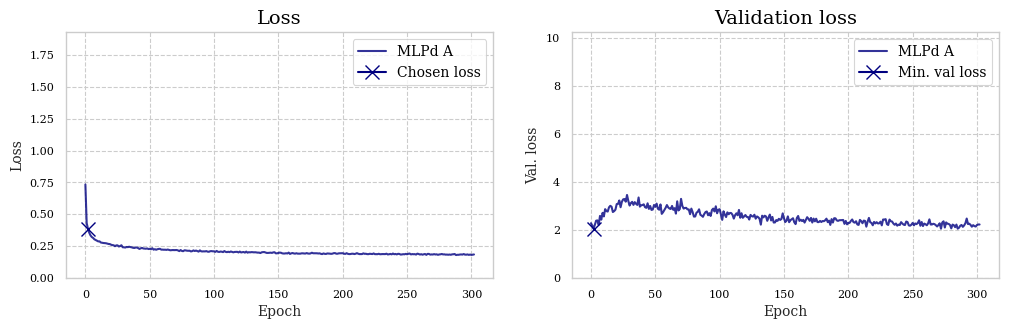

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.3504   |  -1.2369   |
+--------+-------------+------------+


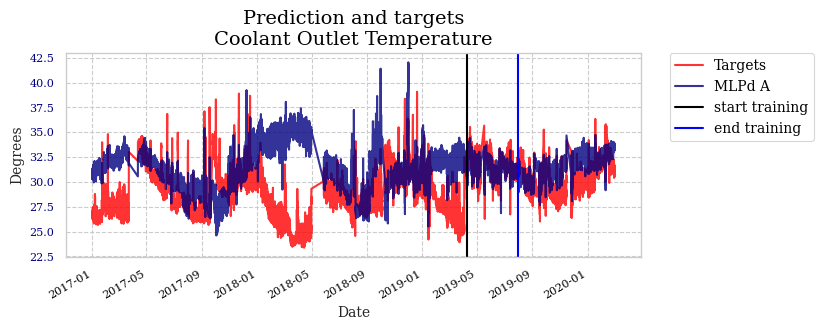

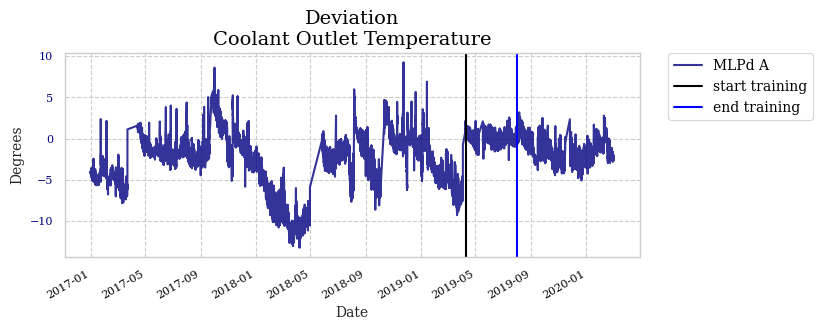

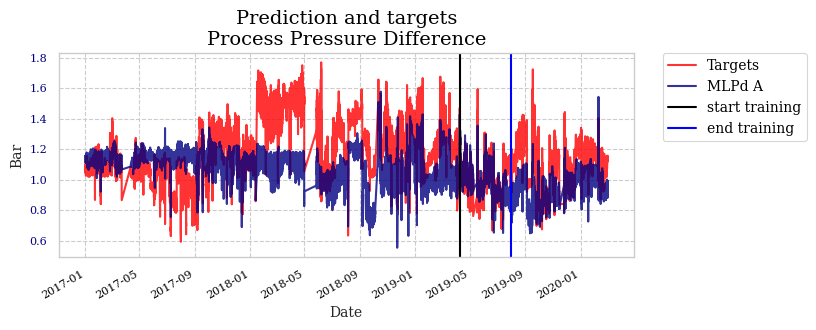

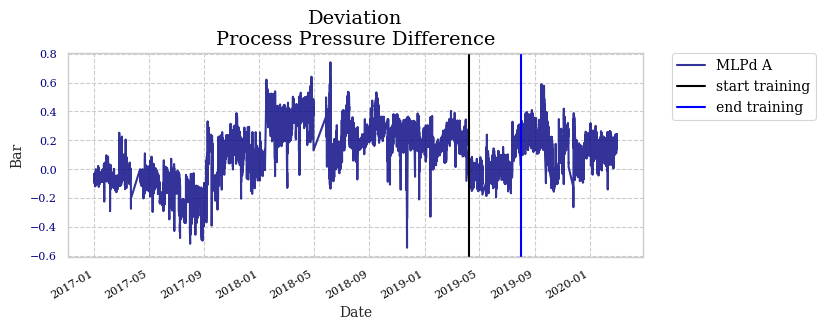

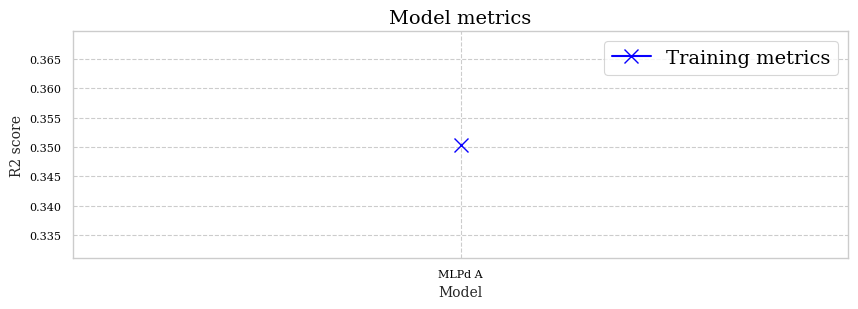

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLPd B was loaded from file
+--------+--------

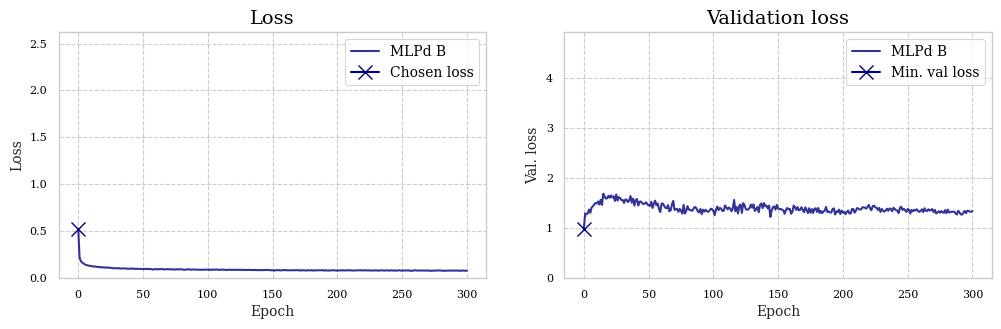

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd B |    0.6746   |  -0.4656   |
+--------+-------------+------------+


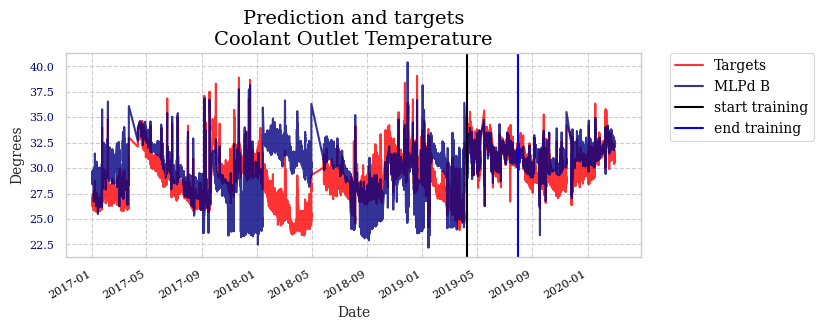

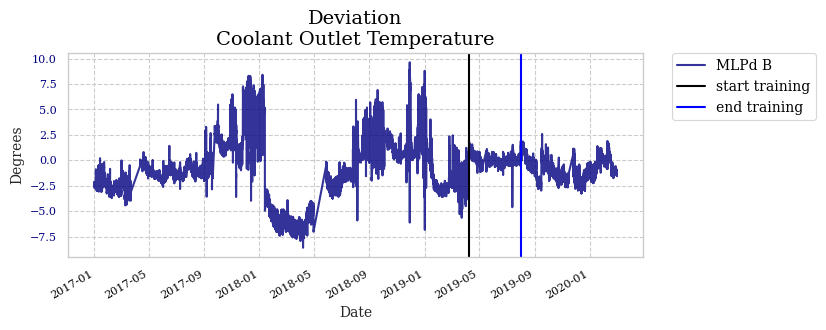

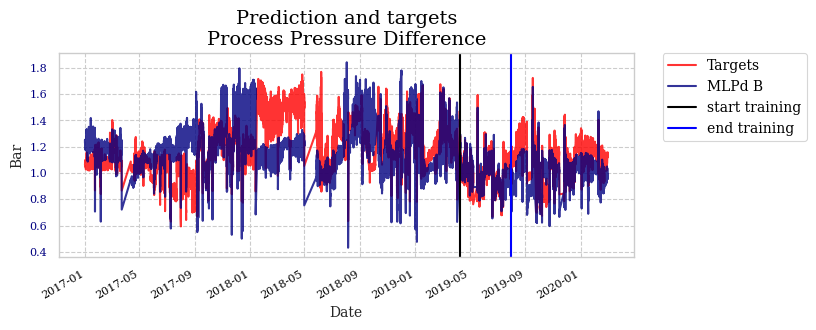

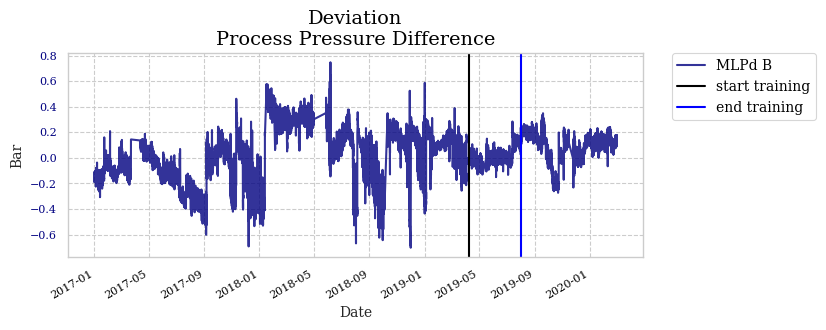

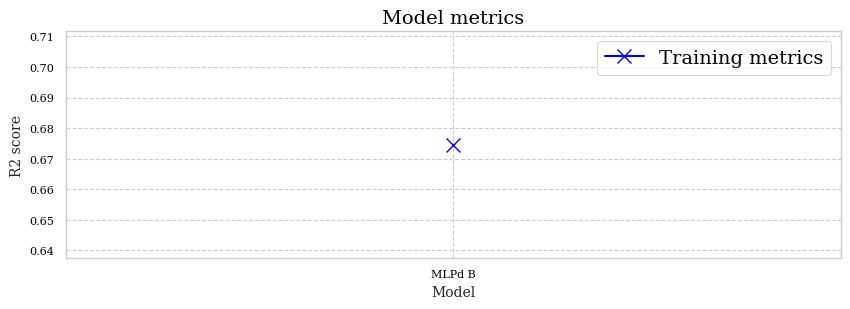

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : FI0027 - Coolant Flow Rate

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLPd C was loaded from file
+--------+-----------+--

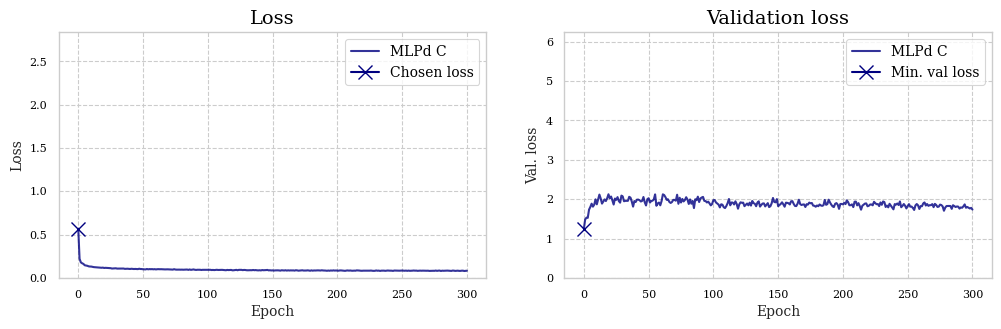

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd C |    0.6151   |  -0.3537   |
+--------+-------------+------------+


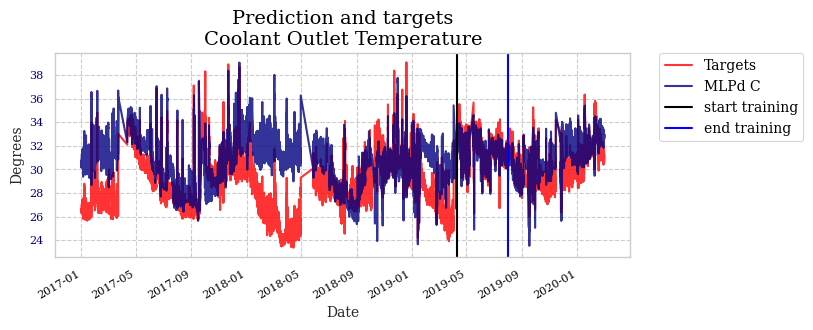

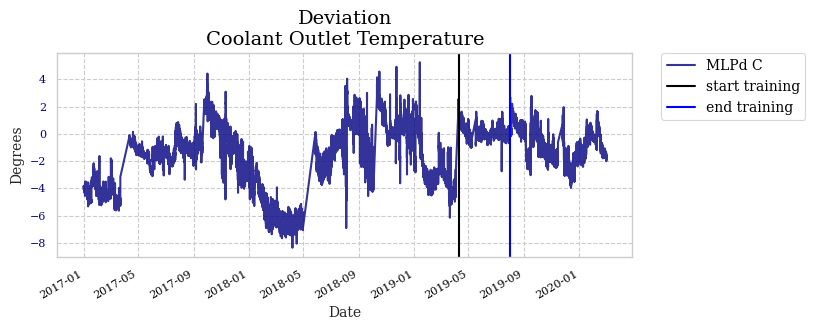

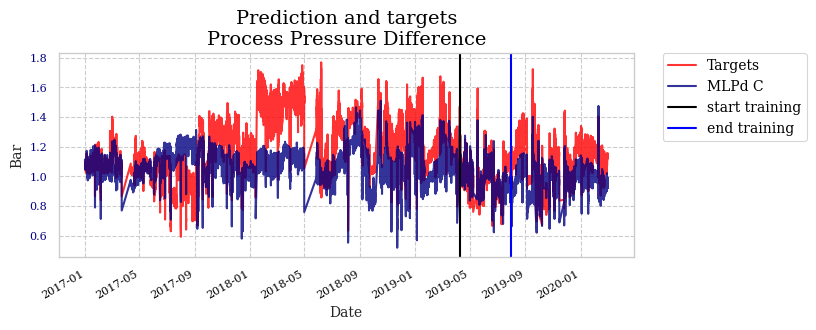

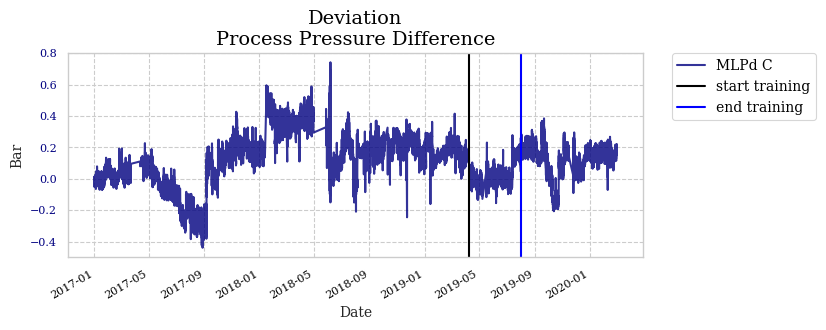

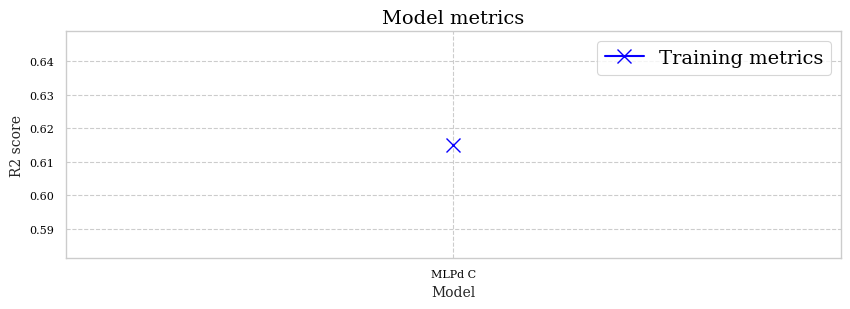

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model MLPd 

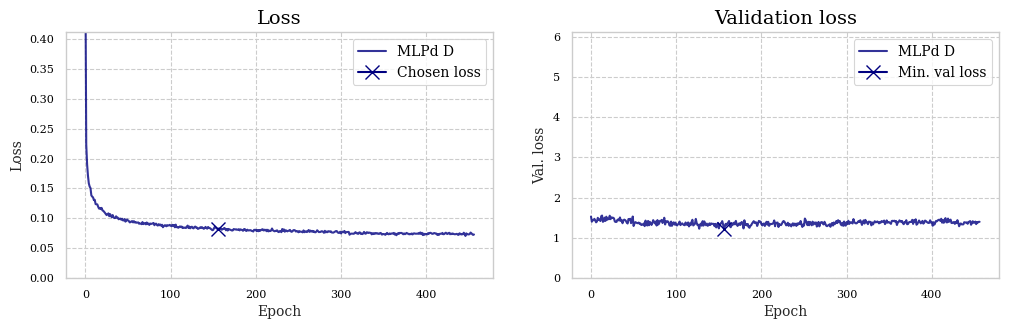

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd D |    0.7107   |   -1.153   |
+--------+-------------+------------+


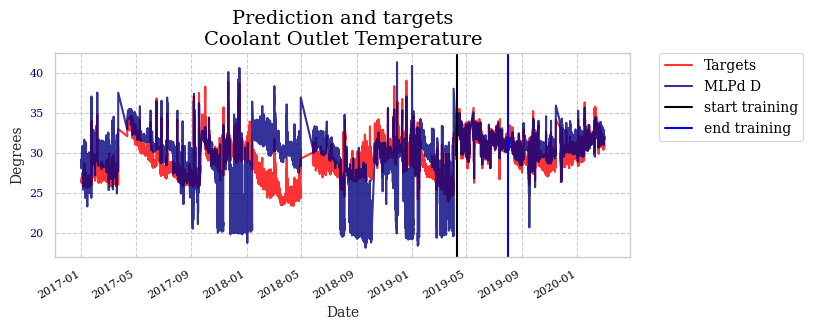

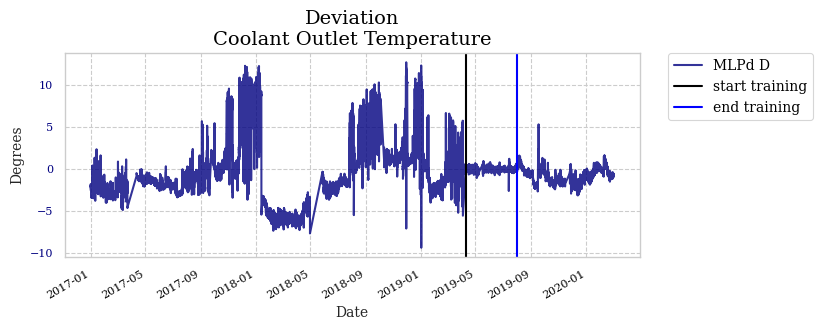

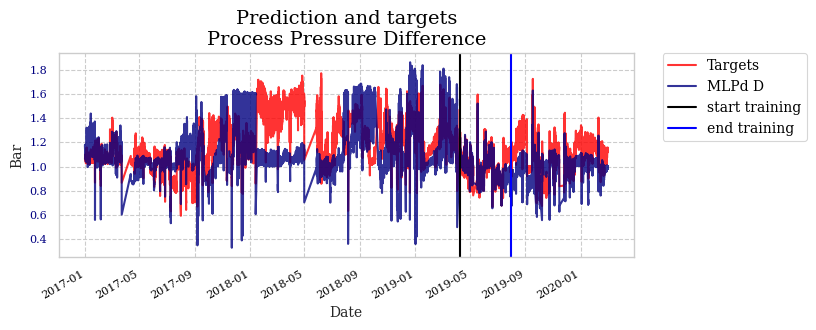

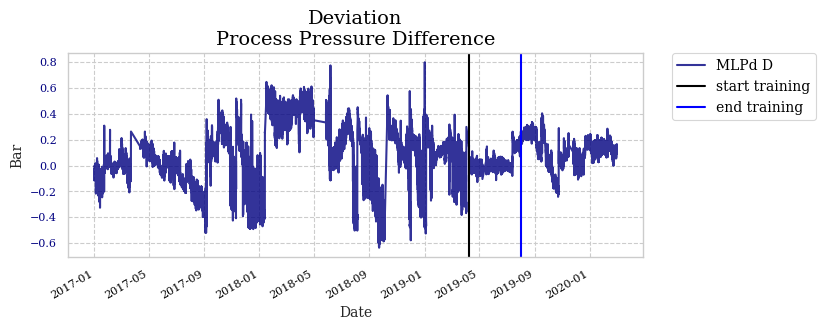

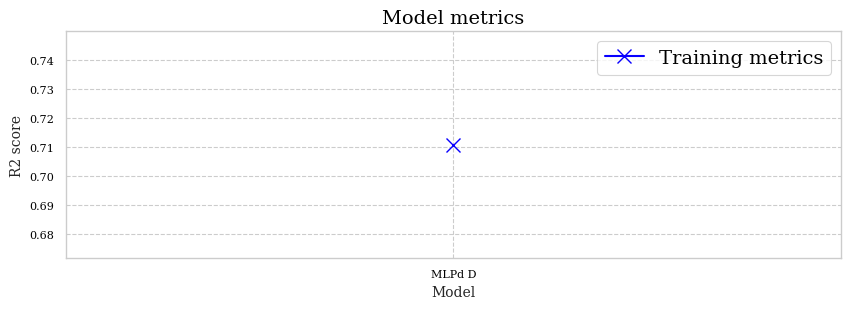

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00

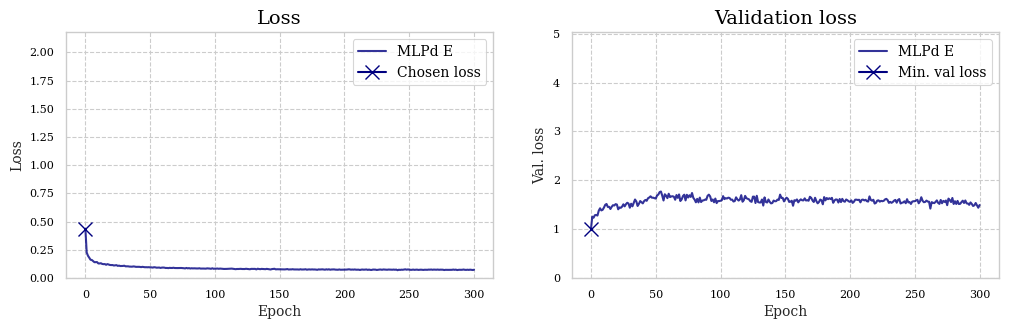

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd E |    0.6665   |  -0.7593   |
+--------+-------------+------------+


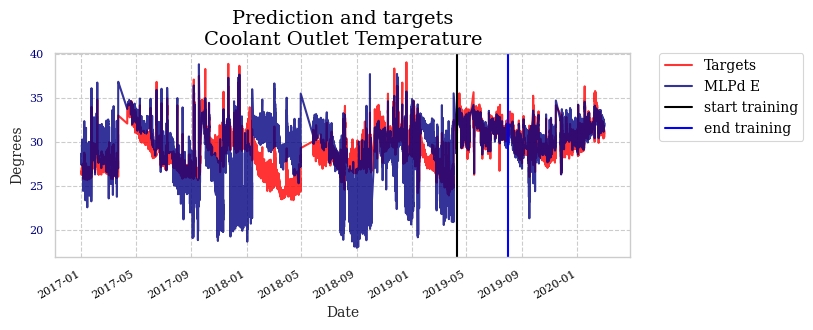

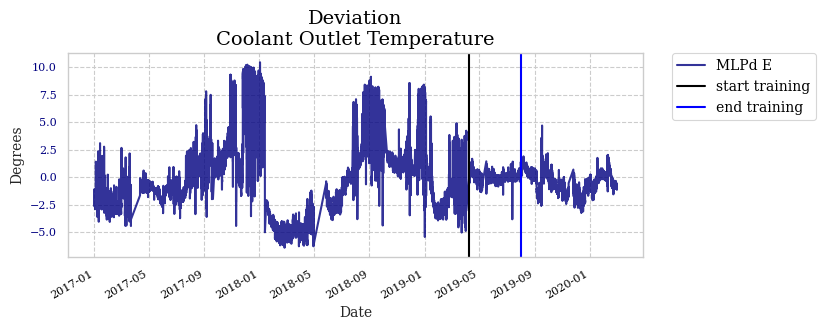

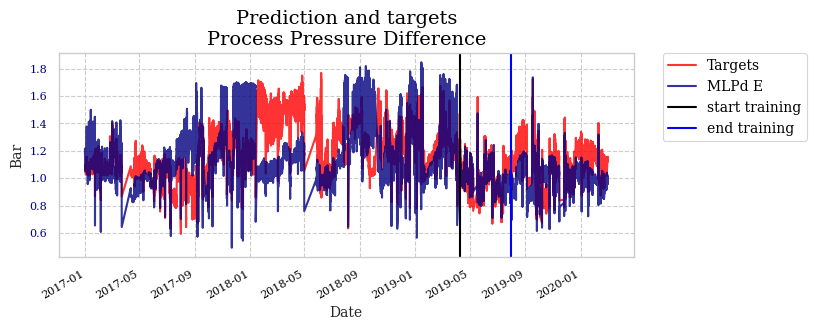

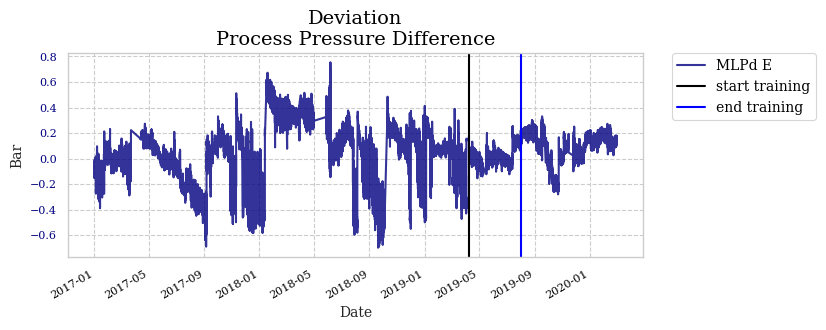

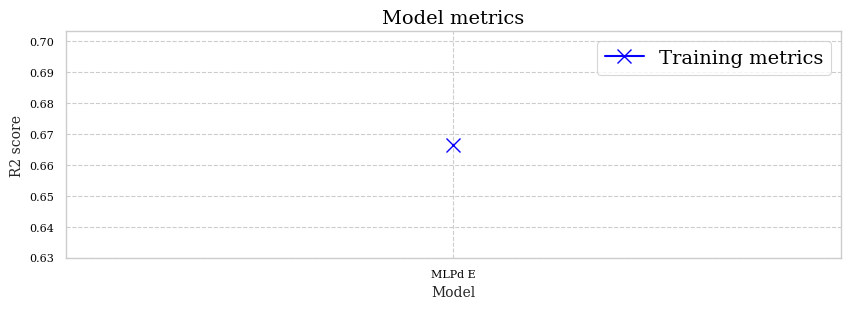

Model prediction scores
+--------+-------------+------------+
| Model  | Train score | Test score |
+--------+-------------+------------+
| MLPd A |    0.3504   |  -1.2369   |
| MLPd B |    0.6746   |  -0.4656   |
| MLPd C |    0.6151   |  -0.3537   |
| MLPd D |    0.7107   |   -1.153   |
| MLPd E |    0.6665   |  -0.7593   |
+--------+-------------+------------+


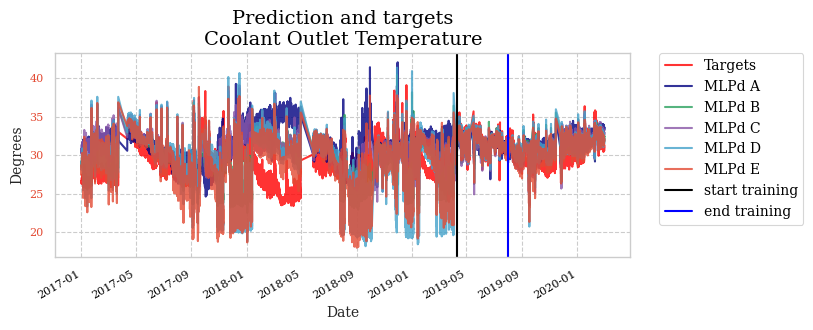

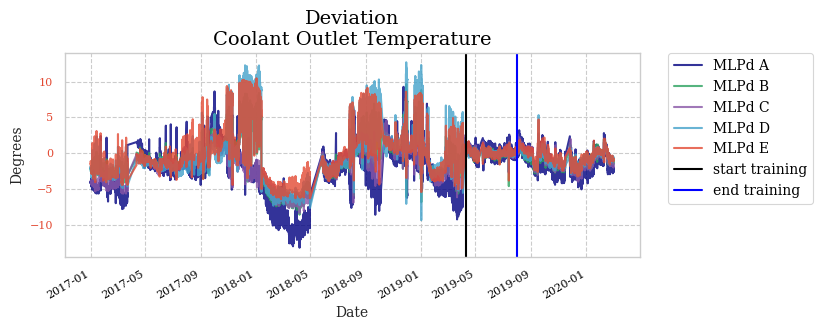

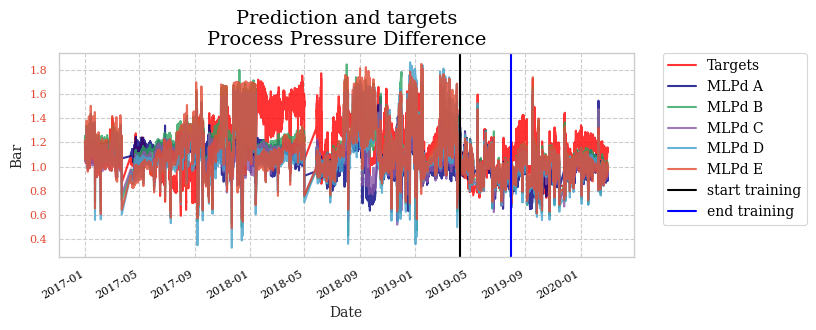

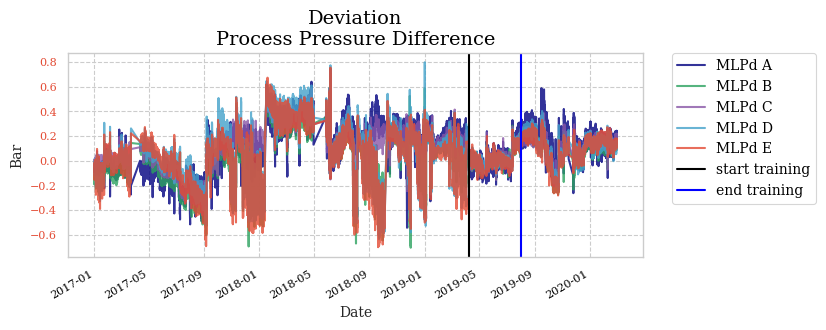

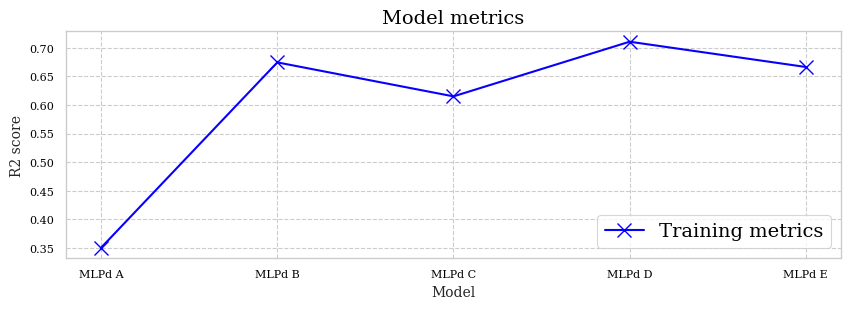

In [8]:
featureComparison(irrelevantColumnsList, filename, columns, traintime, testtime, targetColumns, 16)

## Discussion, Dataset G

Interestingly, only model D has actually converged, while the remaining values have settled with their initial validation loss value. As for the linear models, models using Coolant Valve Opening has overfitted in a similar manner. Predictions for all models, including the model which has converged, are very illogical, often with predicted Coolant Outlet Temperature well above the measured value. The results in general are inconsistent, and it is difficult to assess why the models have not converged.